In [6]:
# !pip install --upgrade pandas

!pip install talos
!pip install statsmodels -U
!pip install --upgrade pytest

In [7]:
# !ls "drive/My Drive/Colab Notebooks/data"

# Imports, loads , Train/test split 

In [8]:
!pip install -U scikit-learn scipy statsmodels

In [9]:
!pip install gensim

In [10]:

#importing required libraries
import pandas as pd
import numpy as np
#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [11]:
#Reading pickle file
import pickle
data = pd.read_pickle('news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels assigned to types 

In [12]:
#displaying the classes present in the dataset
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

fake - [0]
truth - [1]


In [13]:
#Displaying the len of title
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1827
Max len title: 15


In [14]:
'''!unzip gdrive/My\ Drive/GoogleNews-vectors-negative300.zip'''

'!unzip gdrive/My\\ Drive/GoogleNews-vectors-negative300.zip'

In [15]:
#Loading googlenews_vectors model
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, limit=50000)

**Tran/valid/test split**

In [18]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [19]:

X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [20]:
#values to be fitted for train
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]



In [21]:
#Values to be fiited and validates during validation
valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]


In [22]:
#Values to be fitted to testing
test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [23]:
#Setting parameters for CNN
params_cnn = {
    'lr': 0.4,
    'momentum': 0.3,
    'dropout1': 0.2,
    'dropout2': 0.4,
    'filters1Title': 5,
    'denseTitle': 25,
    'filtersContent': 5,
    'denseContent': 28
}

In [24]:
#Some imports...
import tensorflow as tf
import os

from numpy.random import seed
# from tensorflow import set_random_seed

# Convolutional networks

In [25]:

#     set_random_seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [26]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='softmax')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='categorical_crossentropy', metrics=['acc'])
model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 15)]         0           []                               
                                                                                                  
 content_input (InputLayer)     [(None, 1827)]       0           []                               
                                                                                                  
 embed_title (Embedding)        (None, 15, 300)      15000000    ['title_input[0][0]']            
                                                                                                  
 embed_content (Embedding)      (None, 1827, 300)    15000000    ['content_input[0][0]']          
                                                                                              

In [27]:
#Fitting the model
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.2)], validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20
368/368 [==============================] - 382s 1s/step - loss: 0.7597 - acc: 0.4785 - val_loss: 0.6947 - val_acc: 0.4820
Epoch 2/20
368/368 [==============================] - 365s 992ms/step - loss: 0.6945 - acc: 0.4785 - val_loss: 0.6947 - val_acc: 0.4820
Epoch 3/20
368/368 [==============================] - 356s 969ms/step - loss: 0.6945 - acc: 0.4785 - val_loss: 0.6947 - val_acc: 0.4820


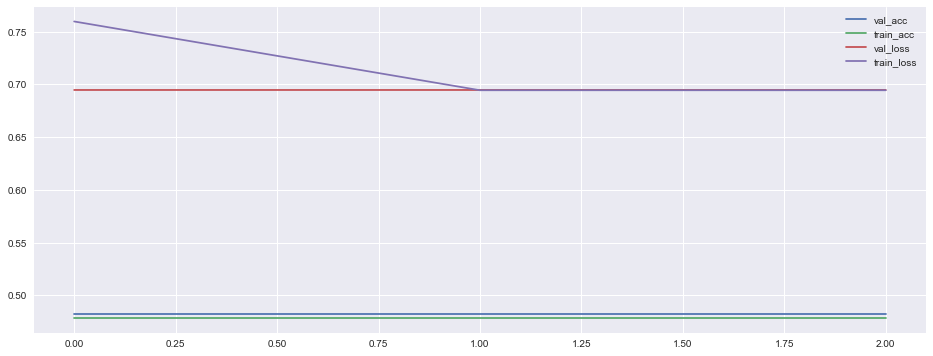

In [28]:
#Plotting a plot
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

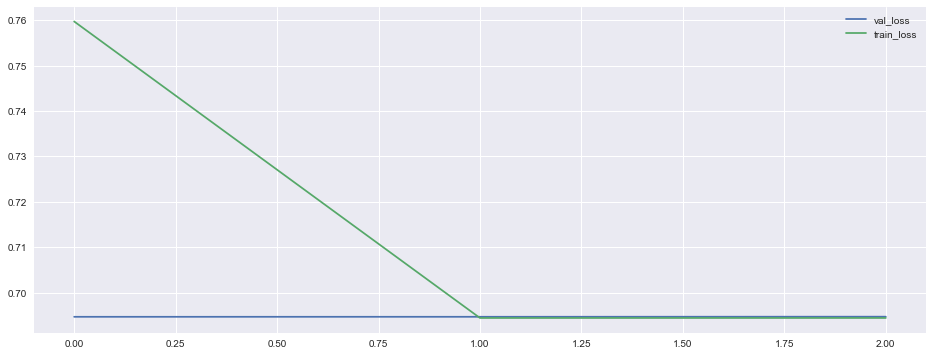

In [29]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [30]:
#predicting the test
test_pred = model.predict(test_fit)

In [31]:
#Saving the model in h5 format
CONV_PATH = 'conv.h5'
model.save(CONV_PATH)

In [32]:

def classify(txt, model):
    #Class names for cifar 10
    class_names = ['fake', 'truth']
    preds = model.predict(txt)
    final = pd.DataFrame({'name' : np.array(class_names),'probability' :preds[0]})
    return final,class_names[classification]

In [ ]:
from flask import Flask,render_template,url_for,request
app = Flask(__name__)

@app.route('/')
def entry_page():
    # template of the webpage
    return render_template('index.html')
@app.route('/predict_object/', methods=['GET', 'POST'])
def render_message():
    #Loading CNN model
    saved_model = 'conv.h5'
    model = load_model(saved_model)
    if request.method == 'POST':
        txt = request.form['txt']
        text = re.sub(r"http\S+", "", text)
        #Tokenize
        tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
        tokens = tokenizer.tokenize(text)
        #Remove non alphanumerica characters
        text = [word for word in tokens if word.isalpha()]    
        return text
    
    try:
        
        #Call classify function to predict the image class using the loaded CNN model
        final,pred_class = classify(text, model)
        print(pred_class)
        print(final)
        
        #Store model prediction results to pass to the web page
        message = "Model prediction: {}".format(pred_class)
        print('Python module executed successfully')
        
    except Exception as e:
        #Store error to pass to the web page
        message = "Error encountered. Try another image. ErrorClass: {}, Argument: {} and Traceback details are: {}".format(e.__class__,e.args,e.__doc__)
        final = pd.DataFrame({'A': ['Error'], 'B': [0]})
        
    #Return the model results to the web page
    return render_template('index.html',
                            message=message)
#Debug is disabled for running in a jupyter notebook
app.run(debug=False)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
[2022-05-07 19:16:44,331] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Python\lib\site-packages\flask\app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Python\lib\site-packages\flask\app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Python\lib\site-packages\flask\app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Python\lib\site-packages\flask\app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\abhis\AppData\Local\Temp/ipykernel_10712/3835653223.py", line 7, in entry_page
    return render_template('index.html')
  File "C:\Python\lib\site-packages\flask\templating.py", line 149, in render_template
    ctx.app.jinja_env.get_or_select_template(template_name_or_list),
  File "C:\Python\lib\si